# Measuring vowels without relying on sex-based assumptions

## Single speaker test
We’ll test out the process of retrieving and merging the data we want to combine for a single utterance, step-by-step before combining the steps into larger code chunks, then we’ll put the process into practice by looping over all the speakers for whom we have data stored in our “data” folder.

#### Step 0: Load in libraries

In [1]:
import numpy as np
np.Inf = np.inf
import pandas as pd
from pathlib import Path
from phonlab.utils import dir2df # must use pip to install
from audiolabel import read_label
import parselmouth as ps
from parselmouth.praat import call as pcall
from parselmouth import Sound
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 1: Save path to data directory, identify speaker directories

In [2]:
# get the path to larger folder containing your data
datadir = Path('./data').absolute()

# create df with by-speaker subfolders containing wav and TextGrid data for one speaker
# fnpat specifies unique wav files so that spkrdf contains each speaker name only once
spkrdf = dir2df(datadir, fnpat='.wav$')
spkrdf

,relpath,fname
0,S00,dollar-store.wav
1,S01,S01_interview.wav
2,S02,S02_interview.wav
3,S03,S03_interview.wav


### Processing TextGrid annotations

#### Step 2: Extract phones and words tiers from TextGrid

Let's establish which vowels we want to work with later to save ourselves time.

In [3]:
vowels = ['IY','IY0', 'IY1', 'IY2', 'IH', 'IH0', 'IH1', 'IH2', 'EY', 'EY0', 'EY1', 'EY2', 
          'EH', 'EH0', 'EH1', 'EH2', 'AH', 'AH0', 'AH1', 'AE', 'AE0', 'AE1', 'AE2', 'ER', 
          'ER0', 'ER1', 'ER2', 'UW', 'UW0', 'UW1', 'UW2','UH', 'UH0', 'UH1', 'UH2', 'OW', 
          'OW0', 'OW1', 'OW2', 'AA', 'AA0', 'AA1', 'AA2', 'AO', 'AO0', 'AO1', 'AO2']

- For the first speaker-specific folder `spkrdf.head(1)`, store phones tier in `phdf`
- Then store words tier in `wrdf`
- The `with_suffix()` method identifies the relevant TG file
- The `tiers` argument uses the names you gave your Praat tiers to identify the correct ones

In [4]:
for row in spkrdf.head(1).itertuples():
    print(f"Processing speaker: {row.relpath}")

    spkrfile = Path(datadir, row.relpath, row.fname).with_suffix('.TextGrid')
    phdf, wrdf = read_label(spkrfile, ftype='praat', tiers=['phones', 'words'])

phdf

Processing speaker: S00


,t1,t2,phones,fname
0,0.000000,0.067296,D,/Users/ambergalvano/Downloads/data/S00/dollar-...
1,0.067296,0.171998,AA,/Users/ambergalvano/Downloads/data/S00/dollar-...
2,0.171998,0.227970,L,/Users/ambergalvano/Downloads/data/S00/dollar-...
3,0.227970,0.296455,ER,/Users/ambergalvano/Downloads/data/S00/dollar-...
4,0.296455,0.426179,S,/Users/ambergalvano/Downloads/data/S00/dollar-...
5,0.426179,0.480835,T,/Users/ambergalvano/Downloads/data/S00/dollar-...
6,0.480835,0.590805,AO,/Users/ambergalvano/Downloads/data/S00/dollar-...
7,0.590805,0.704067,R,/Users/ambergalvano/Downloads/data/S00/dollar-...
8,0.704067,0.720000,,/Users/ambergalvano/Downloads/data/S00/dollar-...


In [5]:
wrdf

,t1,t2,words,fname
0,0.000000,0.296455,dollar,/Users/ambergalvano/Downloads/data/S00/dollar-...
1,0.296455,0.704067,store,/Users/ambergalvano/Downloads/data/S00/dollar-...
2,0.704067,0.720000,,/Users/ambergalvano/Downloads/data/S00/dollar-...


#### Step 3: Subsetting the phones dataframe
- Note that `copy()` ensures the subset of phdf is treated as unique object; avoids warning message

In [6]:
# remove empty segments
phdf = phdf[phdf['phones']!=''].copy()

# add phone duration tier
phdf['phone_dur'] = phdf['t2']-phdf['t1']

# add col for previous phone
phdf['prev']=phdf['phones'].shift() 

# add col for following phone
phdf['nxt']=phdf['phones'].shift(-1)

# keep only vowels, remove short tokens
phdf = phdf[phdf['phones'].isin(vowels) & (phdf['phone_dur'] >= 0.05)].copy()

# check updated df - should be no empty phone segments or segments <0.05s
phdf

,t1,t2,phones,fname,phone_dur,prev,nxt
1,0.067296,0.171998,AA,/Users/ambergalvano/Downloads/data/S00/dollar-...,0.104702,D,L
3,0.227970,0.296455,ER,/Users/ambergalvano/Downloads/data/S00/dollar-...,0.068484,L,S
6,0.480835,0.590805,AO,/Users/ambergalvano/Downloads/data/S00/dollar-...,0.109970,T,R


#### Step 4: Merge phones and words dfs
- Note we specify which columns from each df to retain to avoid duplicates or unwanted columns

In [7]:
# merge matching on closest start times between phone and word annotations
tg = pd.merge_asof(
        phdf[['t1', 't2', 'phones', 'phone_dur', 'prev', 'nxt']],               
        wrdf[['t1', 'words']], 
        on='t1', 
        suffixes=['_ph', '_wd'] # in case there are duplicates
    )

# check merged df is same length and has only specified columns
tg

,t1,t2,phones,phone_dur,prev,nxt,words
0,0.067296,0.171998,AA,0.104702,D,L,dollar
1,0.227970,0.296455,ER,0.068484,L,S,dollar
2,0.480835,0.590805,AO,0.109970,T,R,store


### Setting the FormantPath parameters

#### Step 5: Create parameter dictionaries

In [8]:
# parameters for the FormantPath analysis
fpathparams = {
    'time_step(s)': 0.005,
    'max_num_formants': 5.0,
    'mid_formant_ceiling': 5250,
    'window_len': 0.02,
    'pre_emph_from(Hz)': 50,
    'LPC_model': 'Robust',
    'ceiling_step_size': 0.05,
    'num_steps_up_down': 5,
    'tolerance_1': 1e-6,
    'tolerance_2': 1e-6,
    'num_std_dev': 1.5,
    'max_num_iterations': 5,
    'tolerance': 0.000001,
    'get_source_as_multichan_sound': 'no'
}

# parameters for the Table object
downtotableparams = {
    'coeff_by_track': '3 3 3 3 3',
    'power': 1.25,
    'inc_frame_num': 'no',
    'inc_time': 'yes',
    'num_time_decimal': 6,
    'inc_intensity': 'yes',
    'num_intensity_decimal': 3,
    'inc_num_formants': 'yes',
    'num_freq_decimal': 3,
    'inc_bw': 'yes',
    'inc_optimal_ceil': 'yes',
    'inc_min_stress': 'yes'
}

# dtypes for the Table
downtotabledtype = {
    'time(s)': np.float32,
    'intensity': np.float32,
    'nformants': np.int16,
    'F1(Hz)': np.float32,
    'B1(Hz)': np.float32,
    'F2(Hz)': np.float32,
    'B2(Hz)': np.float32,
    'F3(Hz)': np.float32,
    'B3(Hz)': np.float32,
    'F4(Hz)': np.float32,
    'B4(Hz)': np.float32,
    'F5(Hz)': np.float32,
    'B5(Hz)': np.float32,
    'Ceiling(Hz)': np.float32,
    'Stress': np.float32
}

# list of column names
downtotablecols = list(downtotabledtype.keys())

### Working with the audio file

#### Step 6: Use WAV path to create **sound** object

In [9]:
row = spkrdf.iloc[0]
row

relpath                 S00
fname      dollar-store.wav
Name: 0, dtype: object

In [10]:
# get path to wav files
wav = datadir / row.relpath / row.fname
    
# use path name to create sound object 
snd_stereo = Sound(str(wav))

# extract channel for participant audio
snd = snd_stereo.extract_channel(2)
snd

#### Step 7: Create the FormantPath

In [11]:
fp = pcall(snd, 'To FormantPath...', *fpathparams.values())
pcall(fp, "Save as binary file...", "dollar_store.FormantPath") # save for later
# ds_fp = pcall("Read from file...", "dollar_store.FormantPath") # re-import later using this line
fp

#### Step 8: Down to Table, convert to DataFrame

In [12]:
for phone_row in tg.itertuples(index=False):  
    opttable = pcall(fp, 'Down to Table (optimal interval)...', phone_row.t1,
                     phone_row.t2, *downtotableparams.values())
    optmatrix = pcall(opttable, 'Down to Matrix')

    # Create DataFrame from the extracted formant matrix
    # check this by hand 3/31
    fmtdf = pd.DataFrame({
        c: pd.Series(optmatrix.values[:, i], dtype=downtotabledtype[c]) 
        for i, c in enumerate(downtotablecols)
    })
fmtdf.head()

,time(s),intensity,nformants,F1(Hz),B1(Hz),F2(Hz),B2(Hz),F3(Hz),B3(Hz),F4(Hz),B4(Hz),F5(Hz),B5(Hz),Ceiling(Hz),Stress
0,0.4825,0.0001,4,509.575989,154.852005,735.734009,1531.447998,1327.665039,436.660004,2901.372070,457.036987,NaN,NaN,4088.699951,24.379999
1,0.4875,0.0001,5,500.855988,121.300003,903.226990,1109.473022,1327.067017,402.792999,2837.134033,474.440002,3838.133057,451.546997,4088.699951,24.379999
2,0.4925,0.0001,5,505.562988,101.647003,935.721985,1020.184021,1319.397949,330.584015,2795.620117,532.625977,3740.690918,356.562012,4088.699951,24.379999
3,0.4975,0.0001,5,496.049011,102.564003,1051.103027,862.377014,1280.037964,307.066986,2807.592041,658.797974,3682.310059,305.395996,4088.699951,24.379999
4,0.5025,0.0001,5,525.163025,139.843002,875.791992,774.106018,1290.276978,350.710999,2647.094971,345.786987,3669.975098,166.167999,4088.699951,24.379999


#### Step 9: Add metadata

In [13]:
fmtdf['t1'] = phone_row.t1
fmtdf['t2'] = phone_row.t2
fmtdf['speaker'] = row.relpath
fmtdf['recording'] = row.fname
fmtdf['phones'] = phone_row.phones
fmtdf['phone_dur'] = phone_row.t2 - phone_row.t1
fmtdf['prev'] = phone_row.prev
fmtdf['nxt'] = phone_row.nxt
fmtdf['words'] = phone_row.words
fmtdf.head()

,time(s),intensity,nformants,F1(Hz),B1(Hz),F2(Hz),B2(Hz),F3(Hz),B3(Hz),F4(Hz),...,Stress,t1,t2,speaker,recording,phones,phone_dur,prev,nxt,words
0,0.4825,0.0001,4,509.575989,154.852005,735.734009,1531.447998,1327.665039,436.660004,2901.372070,...,24.379999,0.480835,0.590805,S00,dollar-store.wav,AO,0.10997,T,R,store
1,0.4875,0.0001,5,500.855988,121.300003,903.226990,1109.473022,1327.067017,402.792999,2837.134033,...,24.379999,0.480835,0.590805,S00,dollar-store.wav,AO,0.10997,T,R,store
2,0.4925,0.0001,5,505.562988,101.647003,935.721985,1020.184021,1319.397949,330.584015,2795.620117,...,24.379999,0.480835,0.590805,S00,dollar-store.wav,AO,0.10997,T,R,store
3,0.4975,0.0001,5,496.049011,102.564003,1051.103027,862.377014,1280.037964,307.066986,2807.592041,...,24.379999,0.480835,0.590805,S00,dollar-store.wav,AO,0.10997,T,R,store
4,0.5025,0.0001,5,525.163025,139.843002,875.791992,774.106018,1290.276978,350.710999,2647.094971,...,24.379999,0.480835,0.590805,S00,dollar-store.wav,AO,0.10997,T,R,store


## Looping through speakers
In most use cases, whether we are interested in phonetic variation, social variation, or both, we will want to compare our measurements for sounds of interest across multiple speakers. So long as your data for each speaker is stored in its own folder within `data`, we only need to add a few lines to make this happen. Namely:

- initialize a `fmtdf_list` to store our data for each speaker
- remove the `head()` method from our call to `spkrdf` to loop through the entirety of `spkrdf`
- add `print()` statements to let us know what speaker we're on and what step we're on for that speaker
- use `concat()` as a last step, to append each df in `tglist` into a single `final_fmtdf`

This code could take some time to execute.

In [14]:
fmtdf_list = []

for row in spkrdf.itertuples(index=False):
    print(f"Processing speaker: {row.relpath}")

    print("Working on TG")
    spkrfile = Path(datadir, row.relpath, row.fname)
    phdf, wrdf = read_label(spkrfile.with_suffix('.TextGrid'), ftype='praat', 
                            tiers=['phones', 'words'])

    phdf = phdf[phdf['phones'] != ''].copy()
    phdf['phone_dur'] = phdf['t2'] - phdf['t1']
    phdf['prev'] = phdf['phones'].shift()
    phdf['nxt'] = phdf['phones'].shift(-1)
    phdf = phdf[phdf['phones'].isin(vowels) & (phdf['phone_dur'] >= 0.05)].copy()

    tg = pd.merge_asof(
        phdf[['t1', 't2', 'phones', 'phone_dur', 'prev', 'nxt']],               
        wrdf[['t1', 'words']], 
        on='t1', 
        suffixes=['_ph', '_wd']
    )

    wav = datadir / row.relpath / row.fname
    snd_stereo = Sound(str(wav))
    snd = snd_stereo.extract_channel(2)

    print("Working on FormantPath")
    fp = pcall(snd, 'To FormantPath...', *fpathparams.values())
    pcall(fp, "Save as binary file...", "dollar_store.FormantPath") 

    for phone_row in tg.itertuples(index=False):  
        opttable = pcall(fp, 'Down to Table (optimal interval)...', phone_row.t1,
                         phone_row.t2, *downtotableparams.values())
        optmatrix = pcall(opttable, 'Down to Matrix')

        fmtdf = pd.DataFrame({
            c: pd.Series(optmatrix.values[:, i], dtype=downtotabledtype[c]) 
            for i, c in enumerate(downtotablecols)
        })

        fmtdf['t1'] = phone_row.t1
        fmtdf['t2'] = phone_row.t2
        fmtdf['speaker'] = row.relpath
        fmtdf['recording'] = row.fname
        fmtdf['phones'] = phone_row.phones
        fmtdf['phone_dur'] = phone_row.t2 - phone_row.t1
        fmtdf['prev'] = phone_row.prev
        fmtdf['nxt'] = phone_row.nxt
        fmtdf['words'] = phone_row.words 

        # Append each speaker’s data to the accumulator list
        fmtdf_list.append(fmtdf)

# Combine results from all speakers into final DataFrame
final_fmtdf = pd.concat(fmtdf_list, ignore_index=True)

print("Final formant data compiled.")
final_fmtdf

Processing speaker: S00
Working on TG
Working on FormantPath
Processing speaker: S01
Working on TG
Working on FormantPath
Processing speaker: S02
Working on TG
Working on FormantPath
Processing speaker: S03
Working on TG
Working on FormantPath
Final formant data compiled.


,time(s),intensity,nformants,F1(Hz),B1(Hz),F2(Hz),B2(Hz),F3(Hz),B3(Hz),F4(Hz),...,Stress,t1,t2,speaker,recording,phones,phone_dur,prev,nxt,words
0,0.067500,0.0006,4,563.541016,134.399002,1497.668945,300.160004,2912.206055,362.468994,4251.875000,...,18.969999,0.067296,0.171998,S00,dollar-store.wav,AA,0.104702,D,L,dollar
1,0.072500,0.0005,4,585.226990,105.247002,1497.425049,293.002991,2834.657959,402.588013,4161.104980,...,18.969999,0.067296,0.171998,S00,dollar-store.wav,AA,0.104702,D,L,dollar
2,0.077500,0.0005,4,595.344971,80.324997,1447.144043,222.427994,2753.593018,400.484009,4110.062012,...,18.969999,0.067296,0.171998,S00,dollar-store.wav,AA,0.104702,D,L,dollar
3,0.082500,0.0006,4,638.458008,169.615997,1383.204956,235.783005,2747.660889,406.783997,4121.626953,...,18.969999,0.067296,0.171998,S00,dollar-store.wav,AA,0.104702,D,L,dollar
4,0.087500,0.0006,4,655.804993,127.116997,1377.994019,166.139999,2806.684082,422.973999,4091.020020,...,18.969999,0.067296,0.171998,S00,dollar-store.wav,AA,0.104702,D,L,dollar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138196,1573.076294,0.0120,4,613.754028,519.804993,1382.810059,862.177002,2561.081055,337.622986,3034.551025,...,103.500000,1573.020000,1573.100000,S03,S03_interview.wav,ER0,0.080000,R,SH,for
138197,1573.081299,0.0170,4,533.979004,419.979004,1479.162964,438.527008,2496.750977,264.872009,3229.053955,...,103.500000,1573.020000,1573.100000,S03,S03_interview.wav,ER0,0.080000,R,SH,for
138198,1573.086304,0.0070,4,435.674011,381.576996,1450.681030,633.111023,2356.215088,876.830017,2927.842041,...,103.500000,1573.020000,1573.100000,S03,S03_interview.wav,ER0,0.080000,R,SH,for
138199,1573.091309,0.0040,5,475.747009,361.743011,635.280029,2867.148926,1837.413940,513.320984,2903.514893,...,103.500000,1573.020000,1573.100000,S03,S03_interview.wav,ER0,0.080000,R,SH,for


#### Step 10: Save your completed dataset

Save your completely updated dataset! Append today's date to keep track of your versions.

In [36]:
# Save w/ original filename plus tag for metadata and date for reference
final_fmtdf.to_feather('./formant-paths_04-01-25.ft')

In [15]:
# uncomment to load back in later
# final_fmtdf = pd.read_feather('./formant-paths_04-01-25.ft')
# final_fmtdf 

## Visualize the vowel space
Once we have our data for a few speakers, it's good practice to visualize your vowel formant data to check that it has the expected shape overall.

#### Step 11: Subset for stressed vowels
We'll include only stressed vowels to avoid any effects of vowel reduction.

In [5]:
final_fmtdf = final_fmtdf[final_fmtdf['phones'].astype(str).str[-1] == '1']
final_fmtdf['phones_short'] = final_fmtdf['phones'].str[:-1]
final_fmtdf['phones_short'].unique()

array(['OW', 'IH', 'AH', 'AA', 'EH', 'AE', 'EY', 'AO', 'UW', 'ER', 'UH',
       'IY'], dtype=object)

#### Step 12: Group using by-token medians
Group by token median to work with one set of formant values per vowel token. We'll plot just the first two formants to characterize the vowel space. For diphthongs, depending on your interests, you may want to take one median in the first 20% and another in the last 80% of measurements for a token.

In [6]:
medians = final_fmtdf.groupby(['speaker', 'recording', 't1', 'phones_short']).agg({'F1(Hz)': 'median', 'F2(Hz)': 'median'}).reset_index()
medians.head()

,speaker,recording,t1,phones_short,F1(Hz),F2(Hz)
0,S01,S01_interview.wav,4.7258,OW,479.174011,864.707520
1,S01,S01_interview.wav,10.2100,IH,358.762512,1835.833008
2,S01,S01_interview.wav,10.7100,AH,709.103027,1364.106934
3,S01,S01_interview.wav,11.5100,OW,503.105988,900.085510
4,S01,S01_interview.wav,12.1700,AA,503.427490,1328.932983


#### Step 13: Filter for outliers
Get mean and standard devaition for the first two forman

In [7]:
stats = medians.groupby(['speaker', 'phones_short'])[['F1(Hz)', 'F2(Hz)']].agg(['mean', 'std'])

# flatten the MultiIndex columns
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
# merge the stats with the medians df
medians = medians.merge(stats, on=['speaker', 'phones_short'], how='left')

Filter out tokens more than 1.75 SD away from each by speaker, by vowel mean (taken from the by-token medians).

In [8]:
threshold = 1.75
filtered_meds = medians[
    (medians['F1(Hz)'] >= medians['F1(Hz)_mean'] - threshold * medians['F1(Hz)_std']) &
    (medians['F1(Hz)'] <= medians['F1(Hz)_mean'] + threshold * medians['F1(Hz)_std']) &
    (medians['F2(Hz)'] >= medians['F2(Hz)_mean'] - threshold * medians['F2(Hz)_std']) &
    (medians['F2(Hz)'] <= medians['F2(Hz)_mean'] + threshold * medians['F2(Hz)_std'])
]

#### Step 14: Plot filtered medians for each speaker

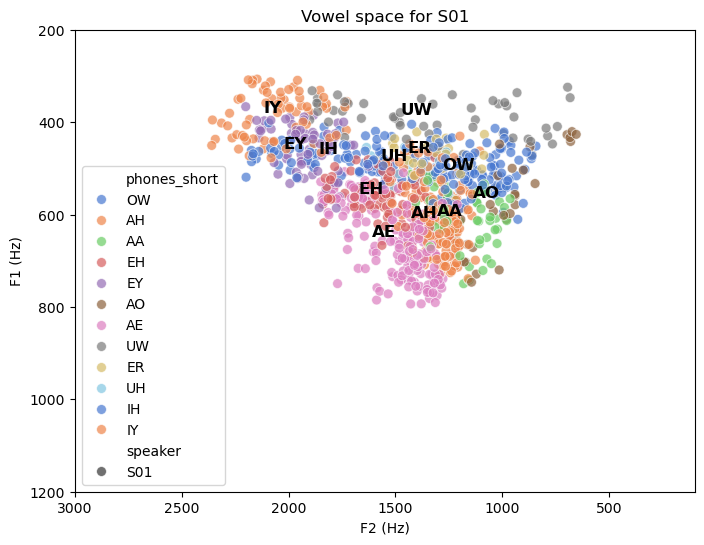

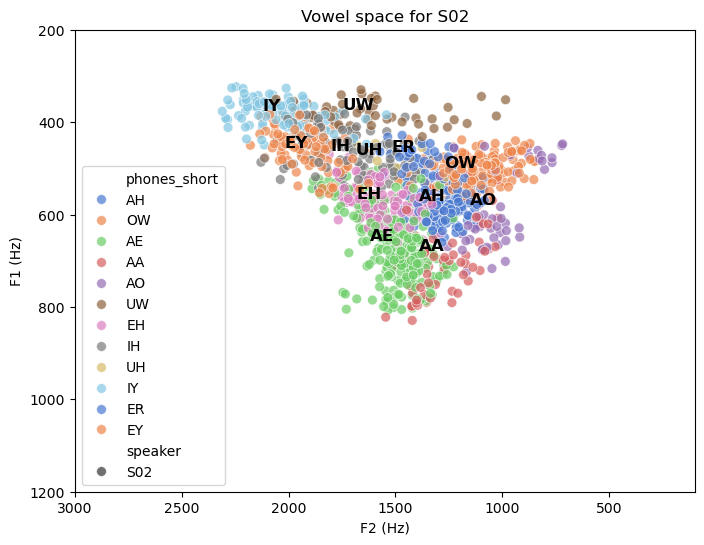

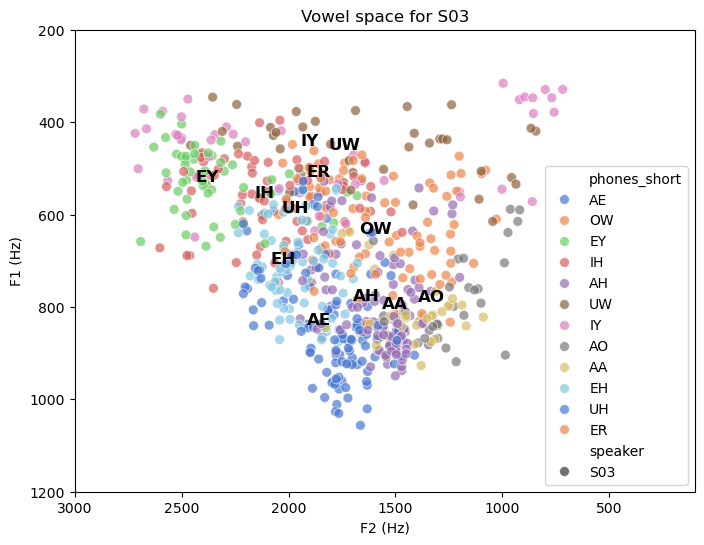

In [14]:
unique_speakers = filtered_meds['speaker'].unique()

for speaker in unique_speakers:
    speaker_data = filtered_meds[filtered_meds['speaker'] == speaker]
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    scatter_plot = sns.scatterplot(
        x='F2(Hz)',
        y='F1(Hz)',
        hue='phones_short',
        style='speaker',
        data=speaker_data,
        s=50,
        alpha=0.7,
        palette='muted'
    )

    plt.xlabel('F2 (Hz)')
    plt.ylabel('F1 (Hz)')

    plt.xlim(100, 3000)
    plt.ylim(200, 1200)

    # Invert axes for vowel plotting
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    # Label means of the medians
    means = speaker_data.groupby('phones_short')[['F1(Hz)', 'F2(Hz)']].mean().reset_index()
    for _, row in means.iterrows():
        plt.text(
            row['F2(Hz)'], row['F1(Hz)'], row['phones_short'], 
            fontsize=12, ha='right', va='bottom', fontweight='bold'
        )

    plt.legend()
    plt.title(f'Vowel space for {speaker}')
    filename = f'vowel_space_{speaker}.png' 
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

Congratulations! 🎉 Now you can make custom visuals of speakers' vowel spaces in a corpus, based on fine-grained formant measurements taken without relying on sex-based assumptions. 

As you can see, there may be more outliers to look into for these speakers, so this tutorial should serve as a starting point that can be used to assess other steps in the pipeline, such as the forced-alignment that produced the annotations, before moving onto statistical analysis.